# AIF Example Workflow

This notebook demonstrates what the **Automated Interpretation Framework (AIF)** does: it evaluates multiple phase interpretations for an XRD pattern by combining four key metrics, then displays the results and plots.

**Run this notebook from the project root** (e.g. `jupyter notebook notebooks/AIF_example_workflow.ipynb` from the repo root).

## 1. Setup and load data

In [5]:
import sys
import json
from pathlib import Path

import pandas as pd

# Add src to path
ROOT = Path.cwd()
if (ROOT / "notebooks").exists():
    ROOT = ROOT  # cwd is project root
else:
    ROOT = ROOT.parent  # cwd is notebooks/
SRC = ROOT / "src"
sys.path.insert(0, str(SRC))

# Output directory for plots (inside notebooks for easy display)
OUTPUT_DIR = ROOT / "notebooks" / "example_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load interpretations and synthesis data
INTERP_PATH = ROOT / "data" / "xrd_data" / "interpretations" / "interpretations.json"
CSV_PATH = ROOT / "data" / "xrd_data" / "synthesis_data.csv"

with open(INTERP_PATH) as f:
    all_interpretations = json.load(f)

df = pd.read_csv(CSV_PATH)

# Pick sample TRI_197 (CaVO2)
SAMPLE_KEY = "TRI_197"
interpretations = all_interpretations[SAMPLE_KEY]
filtered_df = df[df["Name"].str.contains(rf'^{SAMPLE_KEY}$', na=False)]
if filtered_df.empty:
    filtered_df = df[df["Name"].str.contains(rf'^{SAMPLE_KEY.replace("_", "-")}$', na=False)]
target = filtered_df["Target"].iloc[0]
precursors = filtered_df["Precursors"].iloc[0]
temp = filtered_df["Temperature (C)"].iloc[0]
dwell = filtered_df["Dwell Duration (h)"].iloc[0]
furnace = filtered_df["Furnace"].iloc[0]

print(f"Sample: {SAMPLE_KEY}")
print(f"Target phase: {target}")
print(f"\nSynthesis conditions:")
print(f"  Precursors: {precursors}")
print(f"  Temperature: {temp}°C")
print(f"  Dwell time: {dwell} hours")
print(f"  Furnace: {furnace}")
print(f"\nInterpretations: {list(interpretations.keys())}")

Sample: TRI_197
Target phase: CaVO2

Synthesis conditions:
  Precursors: ['CaCO3', 'V2O5']
  Temperature: 600°C
  Dwell time: 12.0 hours
  Furnace: TF-Ar+H2

Interpretations: ['I_1', 'I_2', 'I_3', 'I_4']


## 2. The four metrics

Each interpretation is scored using four metrics that feed into the posterior probability:

### 2.1 Composition balance score

Measures how well the combined phase composition matches the target composition from synthesis. A score of 1 means a perfect match; lower scores indicate missing elements, extra elements, or stoichiometry mismatches.

In [15]:
from IPython.display import display, HTML

print("=" * 70)
print("COMPOSITION BALANCE SCORE (0–1, higher = better match)")
print("=" * 70)
for key, data in interpretations.items():
    bal = data.get("balance_score", 0)
    val = bal if bal is not None else 0
    phases = ", ".join(data.get("phases", []))
    print(f"\n{key}: {val:.3f}")
    print(f"  Phases: {phases}")

COMPOSITION BALANCE SCORE (0–1, higher = better match)

I_1: 0.998
  Phases: CaC2_2, CaV2O5_59

I_2: 0.992
  Phases: CaV2O5_59, Ca5V3O13_176

I_3: 0.375
  Phases: CaC2_2

I_4: 0.375
  Phases: CaCO3_2


### 2.2 LLM interpretation likelihood and explanation

The LLM evaluates whether the phase combination is plausible under the synthesis conditions (temperature, atmosphere, precursors). It returns a likelihood (0–1) and a natural-language explanation.

In [14]:
print("=" * 70)
print("LLM INTERPRETATION LIKELIHOOD (0–1) & EXPLANATION")
print("=" * 70)
for key, data in interpretations.items():
    llm = data.get("LLM_interpretation_likelihood", 0)
    val = llm if llm is not None else 0
    expl = data.get("LLM_interpretation_explanation", "(no explanation)")
    print(f"\n{key}: {val:.3f}")
    print(f"  Explanation: {expl[:1000]}..." if len(str(expl)) > 1000 else f"  Explanation: {expl}")

LLM INTERPRETATION LIKELIHOOD (0–1) & EXPLANATION

I_1: 0.400
  Explanation: The presence of CaC₂ is highly unlikely, significantly reducing the plausibility of this interpretation. CaV₂O₅ is plausible, but the overall interpretation does not align well with the target phase or expected reaction products.

I_2: 0.550
  Explanation: This interpretation is more plausible than I_1 due to the absence of CaC₂. The presence of CaV₂O₅ and Ca₅V₃O₁₃ suggests incomplete reaction towards the target phase, but the phases are chemically reasonable under the given conditions.

I_3: 0.100
  Explanation: This interpretation is highly implausible due to the exclusive presence of CaC₂, which is not expected to form under the synthesis conditions. The lack of any vanadium-containing phases further reduces its credibility.

I_4: 0.200
  Explanation: The presence of only CaCO₃ suggests an incomplete reaction, which is unlikely given the synthesis conditions. The absence of any vanadium-containing phases fu

### 2.3 RWP (weighted profile R-factor)

Measures how well the calculated XRD pattern fits the observed pattern. **Lower RWP is better** (typical good fits are &lt; 20). The framework normalizes RWP to a 0–1 scale for combination with other metrics.

In [13]:
print("=" * 70)
print("RWP (lower = better fit) & NORMALIZED RWP (0–1, higher = better)")
print("=" * 70)
for key, data in interpretations.items():
    rwp = data.get("rwp", "—")
    norm = data.get("normalized_rwp")
    val = norm if norm is not None else "—"
    norm_str = f"{val:.3f}" if val != "—" else "—"
    print(f"\n{key}: RWP = {rwp}, normalized = {norm_str}")

RWP (lower = better fit) & NORMALIZED RWP (0–1, higher = better)

I_1: RWP = 16.16, normalized = 0.731

I_2: RWP = 16.27, normalized = 0.729

I_3: RWP = 18.05, normalized = 0.699

I_4: RWP = 17.39, normalized = 0.710


### 2.4 Score (peak matching)

Measures how well the calculated peaks match the observed peaks (peak positions and intensities). **Higher score is better.** The raw score is normalized via a sigmoid for combination with other metrics.

In [11]:
print("=" * 60)
print("SCORE (peak matching, higher = better) & NORMALIZED SCORE (0–1)")
print("=" * 60)
for key, data in interpretations.items():
    score = data.get("score", "—")
    norm = data.get("normalized_score")
    norm_pct = f"{norm*100:.1f}%" if norm is not None else "—"
    print(f"\n{key}: score = {score}, normalized = {norm_pct}")

SCORE (peak matching, higher = better) & NORMALIZED SCORE (0–1)

I_1: score = 0.06559202026598322, normalized = 37.2%

I_2: score = 0.1507639717187302, normalized = 43.8%

I_3: score = 0.030591620794814495, normalized = 34.6%

I_4: score = 0.202231659184716, normalized = 48.0%


## 3. Combined posterior probability

The framework combines these metrics into a **prior** (from composition balance + LLM) and **fit quality** (from RWP + score), then computes the **posterior probability** for each interpretation.

In [19]:
print("=" * 70)
print("POSTERIOR PROBABILITIES (sum to 1)")
print("=" * 70)
for key, data in interpretations.items():
    post = data.get("posterior_probability") 
    val = post if post is not None else 0
    print(f"{key}: {val:.3f}")

POSTERIOR PROBABILITIES (sum to 1)
I_1: 0.349
I_2: 0.389
I_3: 0.116
I_4: 0.146


## 4. Generate and display plots

In [20]:
# Patch get_output_dir so plots save to our notebook output folder
import utils
_orig = utils.get_output_dir
def _patched(target, project_number):
    p = OUTPUT_DIR / project_number.split("_")[0] / target / project_number
    p.mkdir(parents=True, exist_ok=True)
    return str(p)
utils.get_output_dir = _patched

# Generate plots
from utils import plot_phase_and_interpretation_probabilities, plot_metrics_contribution

plot_phase_and_interpretation_probabilities(interpretations, SAMPLE_KEY, filtered_df, target)
plot_metrics_contribution(interpretations, SAMPLE_KEY, target)

utils.get_output_dir = _orig  # restore

2026-01-30 21:17:19,377	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Interpretation probabilities (stacked by phase):


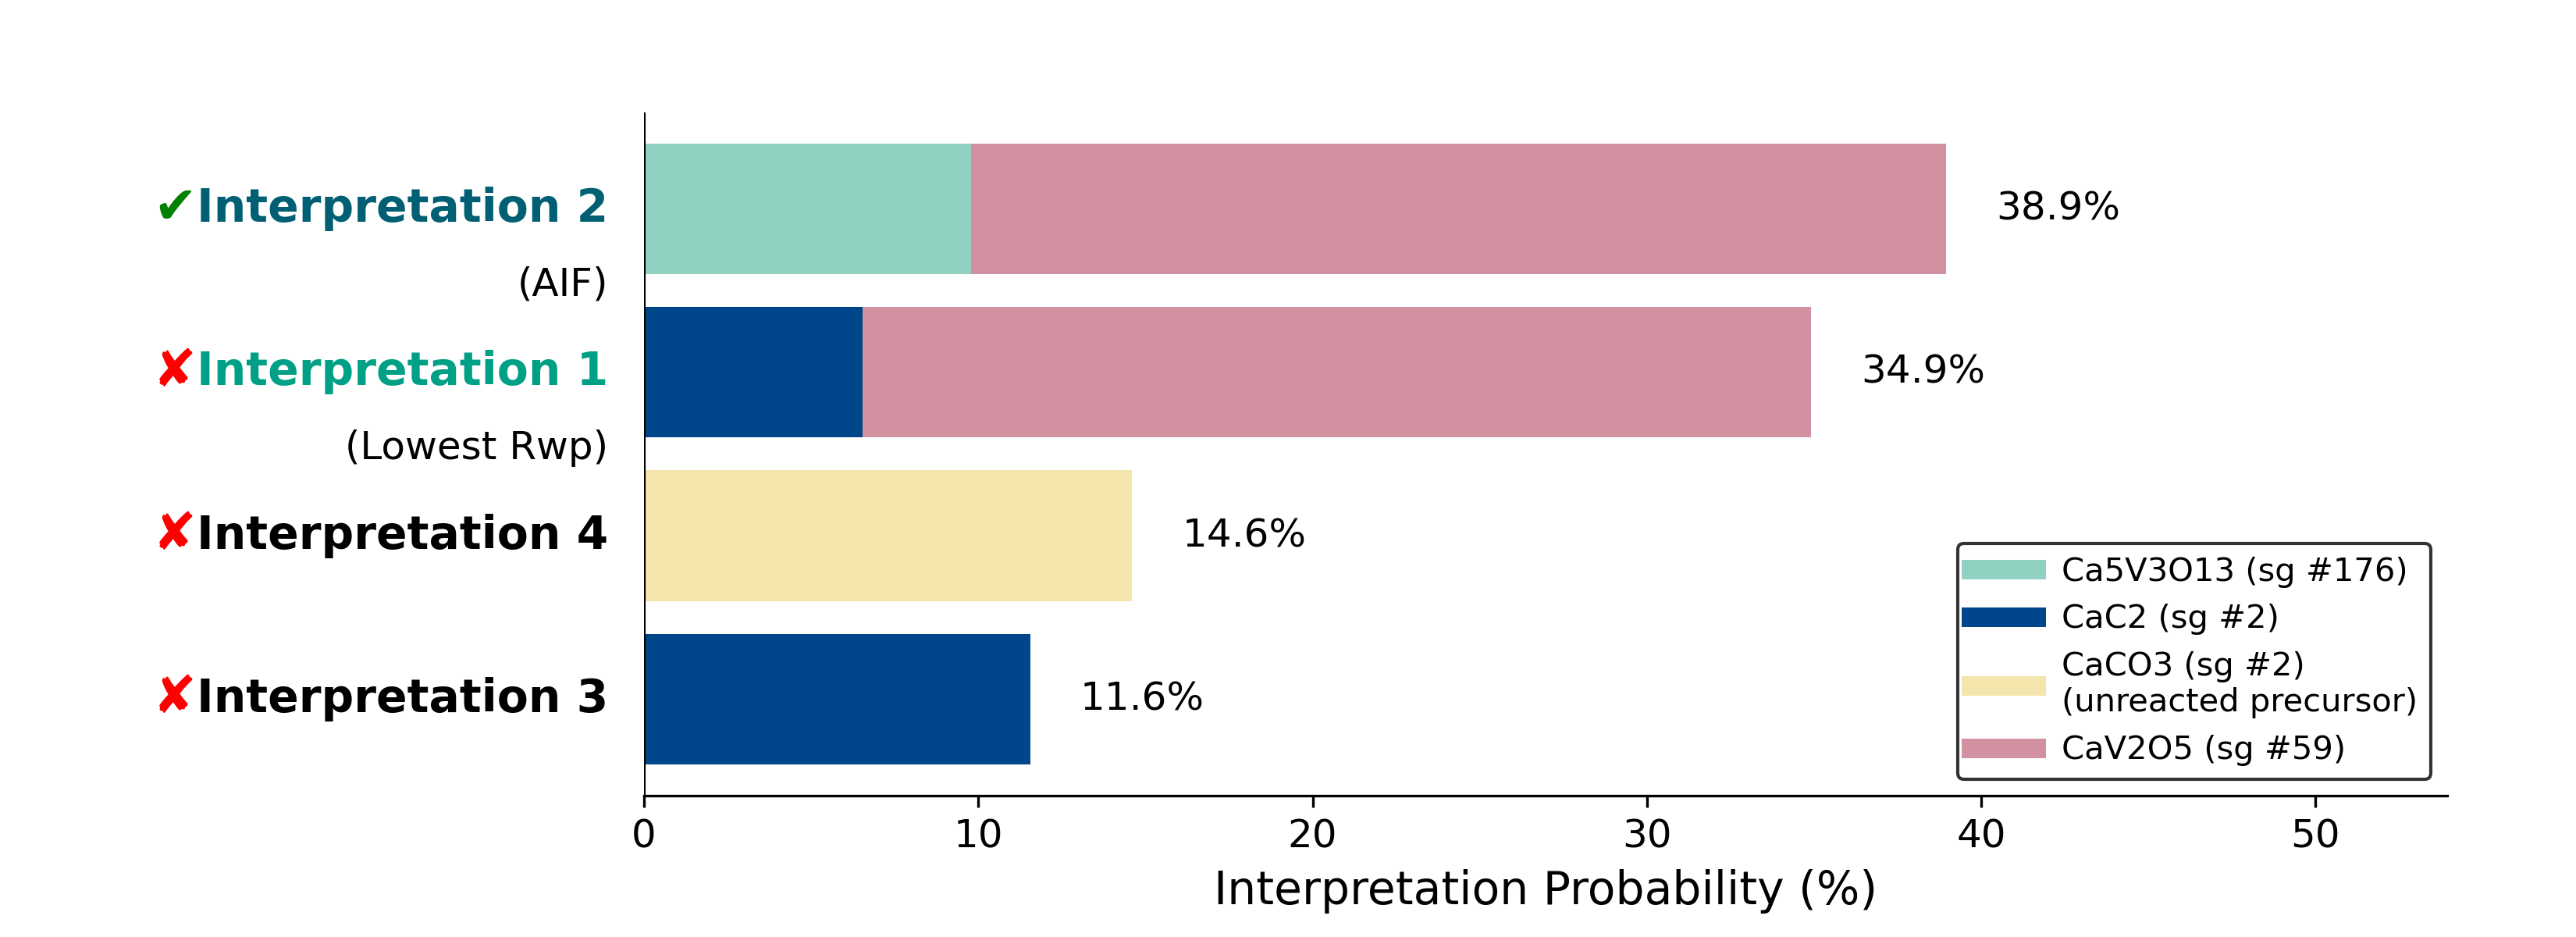


Phase probabilities (stacked by interpretation):


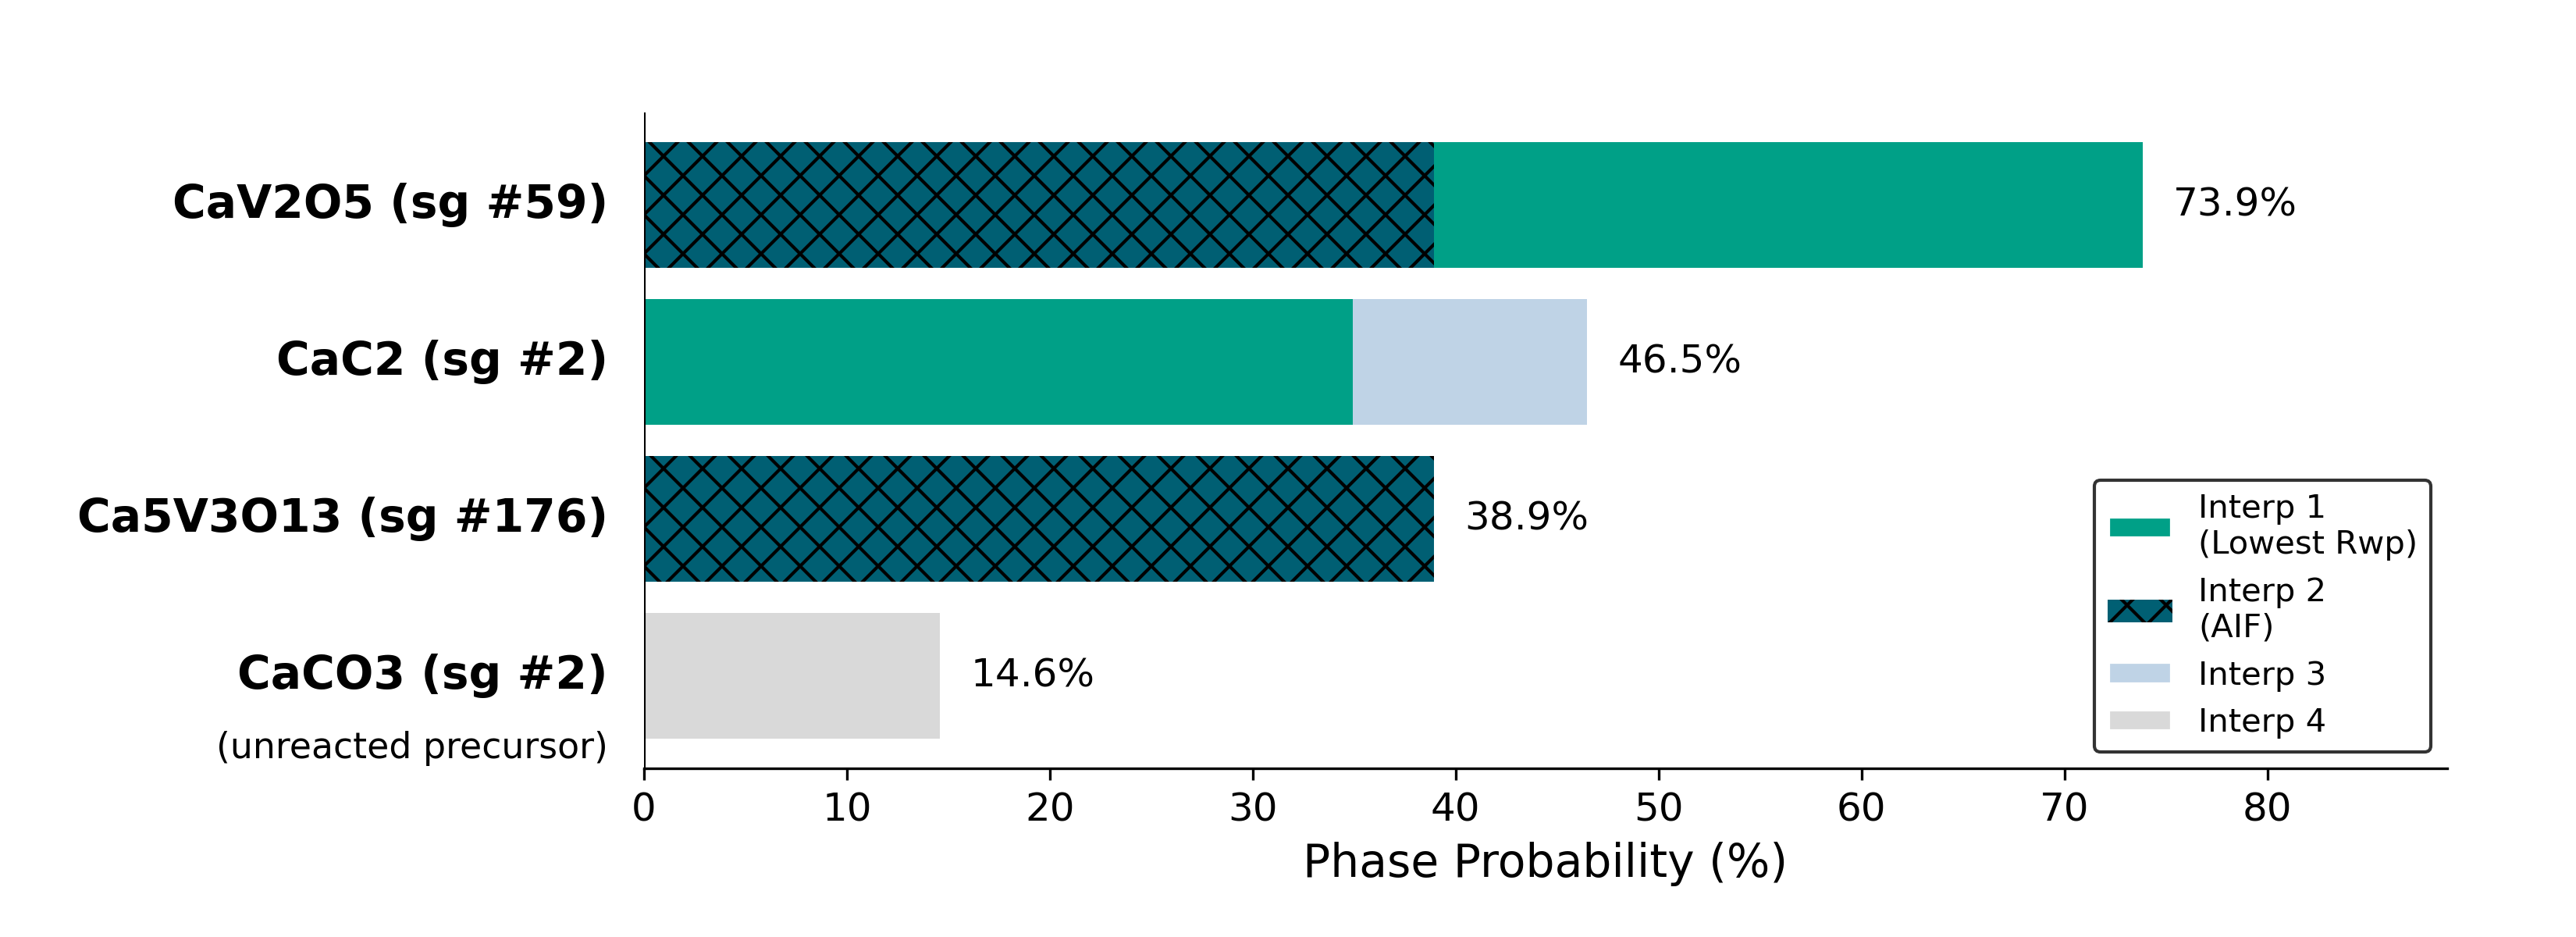


Metrics contribution (Rwp, score, balance, LLM):


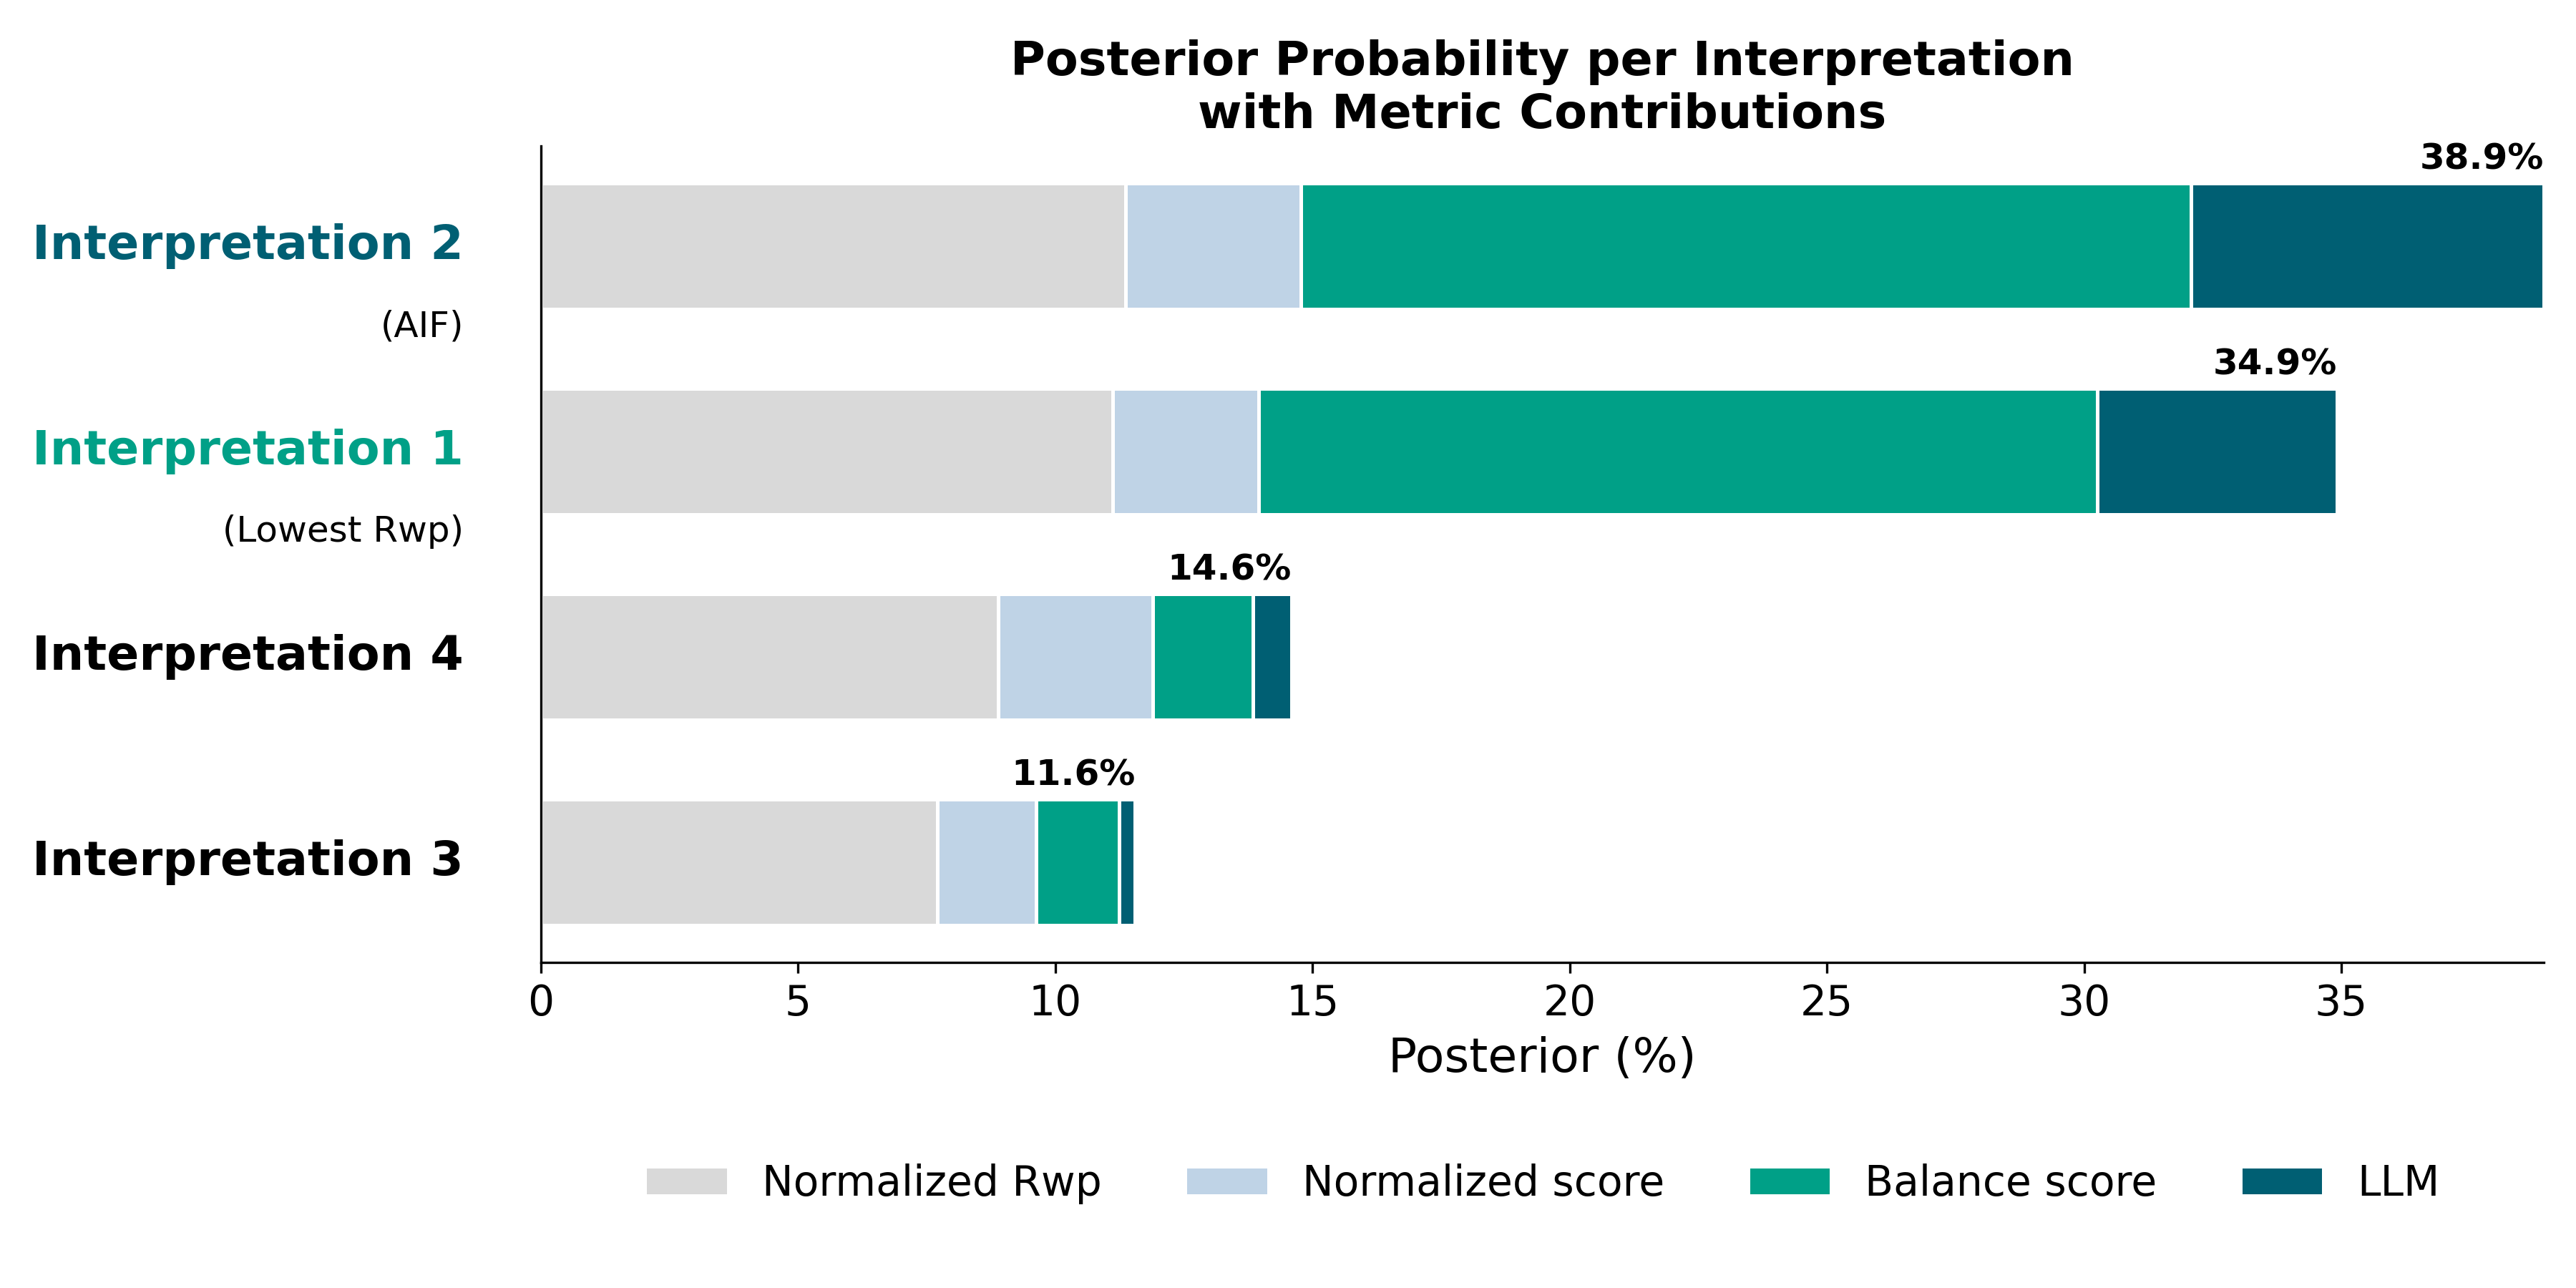

In [21]:
from IPython.display import Image, display

plot_dir = OUTPUT_DIR / "TRI" / target / SAMPLE_KEY

# Display interpretation probabilities and phase probabilities
interp_plot = plot_dir / "interpretation_probabilities.png"
phase_plot = plot_dir / "phases_probabilities.png"
metrics_plot = plot_dir / "metrics_contribution_breakdown.png"

if interp_plot.exists():
    print("Interpretation probabilities (stacked by phase):")
    display(Image(filename=str(interp_plot), width=700))
if phase_plot.exists():
    print("\nPhase probabilities (stacked by interpretation):")
    display(Image(filename=str(phase_plot), width=700))
if metrics_plot.exists():
    print("\nMetrics contribution (Rwp, score, balance, LLM):")
    display(Image(filename=str(metrics_plot), width=700))